In [1]:
# [MNIST] Download the dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
print(mnist)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

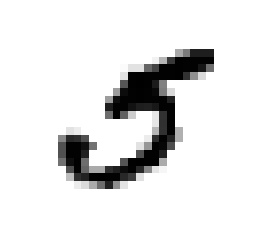

Label: 5.0


In [4]:
# display one digit
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
              interpolation="nearest")
plt.axis("off")
plt.show()
print("Label: %s" %y[36000])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle training set to guarantee that all cross-validations folds will be similar
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
# [training a binary classifier]
y_train_5 = (y_train == 5) # true for 5, false for not 5
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [7]:
# [Implementing cross-validation] (aka cross_val_score())

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.96785, 0.96155 and 0.9638

0.95395
0.9634
0.9532


In [8]:
# use cross_val_score to evaluate the SGDClassifier

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95395,  0.9634 ,  0.9532 ])

In [9]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9081 ,  0.91165,  0.9092 ])

In [10]:
# Evaluate with [Confusion Matrix]
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)
# first row is about non-5, first column is non-5 correctly classified(TN), the second is wrongly(FP)
# second row is about 5, first column is wrongly classified(FN), the second is correctly classified(TP)

[[52932  1647]
 [  942  4479]]


In [11]:
# precision = TP/TP+FP
# recall = TP/TP+FN
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("precision: %s \nrecall: %s" %(precision,recall))

precision: 0.731145935357 
recall: 0.826231322634


In [12]:
# [Precision and recall]
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))

# precision = ha classificat correctament el 84% dels 5s
# recall = ha detectat el 73.7% dels 5s existents

0.731145935357
0.826231322634


In [13]:
# F1 score combines the precision and recall 2/((1/precision)+(1/recall))

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77578591842036893

In [14]:
# [precision/recall tradeoff]
# set threshold for the preceision/recall

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 173913.33943962])

In [15]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [16]:
# lets raise the threshold
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

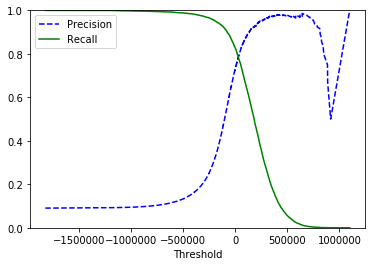

In [17]:
# calculate scores for all the instances
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# and compute the preceision / recall for all the possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# finally plot the precision/recalls as a function of the thresholds

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [18]:
y_train_pred_90 = (y_scores > 70000)
precis = precision_score(y_train_5, y_train_pred_90)
reca = recall_score(y_train_5, y_train_pred_90)

print("Precision: %s - Recall: %s" %(precis,reca))
# with a threshold in 70000 we will get a 91.6% of precision and 60.9% of recall

Precision: 0.844381656162 - Recall: 0.716657443276


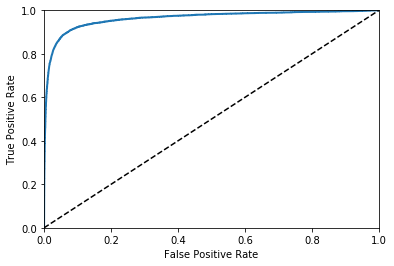

In [19]:
# [the roc curve]
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
# calculate area under the curve, more close to 1 better
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96317549801872759

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


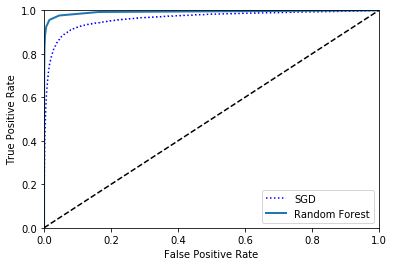

In [21]:
# roc with random forests
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores_forest)

0.99251332225553079

In [23]:
# [multiclass classification]
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit]) # digit 5

some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-187703.56107062 -511328.30470264 -291362.6804446  -149828.04297149
  -346222.38575636  173913.33943962 -699609.29347125 -360469.35420923
  -707259.27386836 -628361.80708748]]


In [24]:
np.argmax(some_digit_scores)

5

In [25]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [26]:
sgd_clf.classes_[5]

5.0

In [27]:
# using a OvO strategy
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

len(ovo_clf.estimators_)

45

In [28]:
# with a random forests, this doesn't need to run OvO because
# random forests can classify in multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0.1,  0.3,  0. ,  0.5,  0. ,  0. ,  0. ,  0.1]])

In [29]:
# evaluate with cross validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.82538492,  0.8540427 ,  0.85622843])

In [30]:
# try now scaling the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90911818,  0.91349567,  0.90693604])

In [31]:
# [Error Analysis]
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5739    3   23    9   12   48   40    8   37    4]
 [   1 6493   45   26    7   39    8    8  104   11]
 [  54   41 5327   97   76   27   90   53  176   17]
 [  48   42  138 5369    2  218   36   56  130   92]
 [  18   31   43    6 5385   10   52   27   73  197]
 [  70   45   31  187   72 4622  109   26  168   91]
 [  33   28   50    2   48   91 5619    3   44    0]
 [  29   23   73   31   65    9    4 5766   18  247]
 [  50  165   73  154   13  164   58   27 4997  150]
 [  41   37   25   87  177   38    3  196   71 5274]]


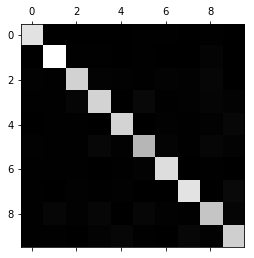

In [32]:
# plot the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

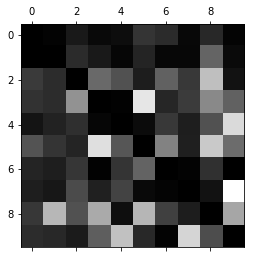

In [33]:
# focus on the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# the correct classifications are with 0 value
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
# EXTRA plot digits functions
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Plot all digits
# plt.figure(figsize=(9,9))
# example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
# plot_digits(example_images, images_per_row=10)
# save_fig("more_digits_plot")
# plt.show()

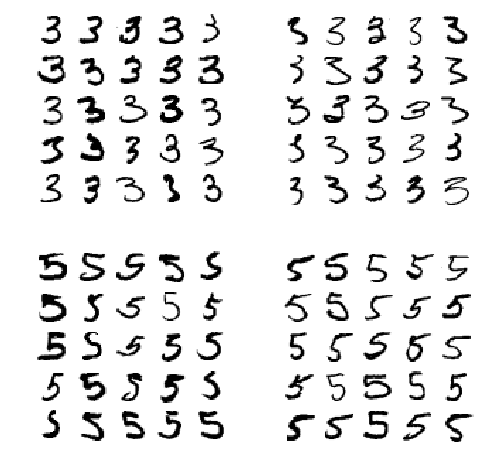

In [35]:

# analyse individual errors
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()
# left classified as 3, right classified as 5

In [36]:
# [Multilabel Classification]
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])


array([[False,  True]], dtype=bool)

In [37]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.96805494283152371

In [42]:
# [Multioutput Classification]

# add noise to the MNIST images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

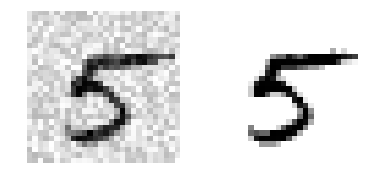

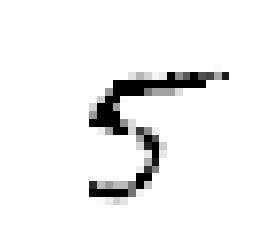

In [54]:
# noise and original images
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

# clean image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)